In [31]:
import cv2
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import ultralytics
from ultralytics import YOLO, SAM
ultralytics.checks()
print(f"CUDA available {torch.cuda.is_available()}")

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 Super with Max-Q Design, 7967MiB)
Setup complete ✅ (16 CPUs, 62.5 GB RAM, 390.7/915.3 GB disk)
CUDA available True


In [24]:
boxes_model = YOLO('.data/runs/train/yolov11_box14/weights/best.pt')
sam_model = SAM("sam2.1_b.pt")

In [ ]:
expected_width=20
expected_height=19
expected_depth=20

In [66]:
def resize(img, target_width = 300):
    height, width = img.shape[:2]
    new_height: int = int(target_width / (width / height))
    return cv2.resize(img, (target_width, new_height), interpolation=cv2.INTER_AREA)

def imshow(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def plot_mask_contours(image, masks, thickness=2, figsize=(12, 12)):
    """
    Plot contours of SAM masks on the image
    
    Args:
        image: RGB image as numpy array (H, W, 3)
        masks: Predicted masks as numpy array (N, H, W)
        thickness: Line thickness for contours
        figsize: Size of the figure as (width, height)
    """
    plt.figure(figsize=figsize)
    plt.imshow(image)
    
    # Generate random colors for contours
    colors = [np.random.rand(3) for _ in range(len(masks))]
    
    # Plot contours for each mask
    for mask, color in zip(masks, colors):
        plt.contour(mask, colors=[color], linewidths=thickness)
    
    plt.axis('off')
    plt.show()

In [63]:
image = cv2.imread('.data/capture/screenshots/image1.jpg')
image = resize(image)
result = boxes_model.predict(source=image)[0]


0: 320x320 2 Cartons, 9.9ms
Speed: 17.6ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 320)


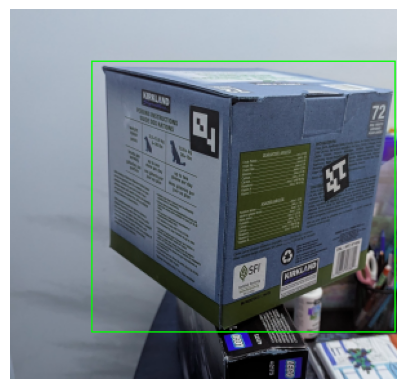

In [64]:
image_pred = image.copy()
bbox = []
for box in result.boxes:
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    conf = box.conf[0]
    if conf > 0.5:
        bbox.append(((int(x1), int(y1)), (int(x2), int(y2))))
        cv2.rectangle(image_pred, (int(x1), int(y1)), (int(x2), int(y2)), color=(0,255, 0), thickness=1)

imshow(image_pred)

ROI

0: 1024x1024 1 0, 256.5ms
Speed: 19.5ms preprocess, 256.5ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


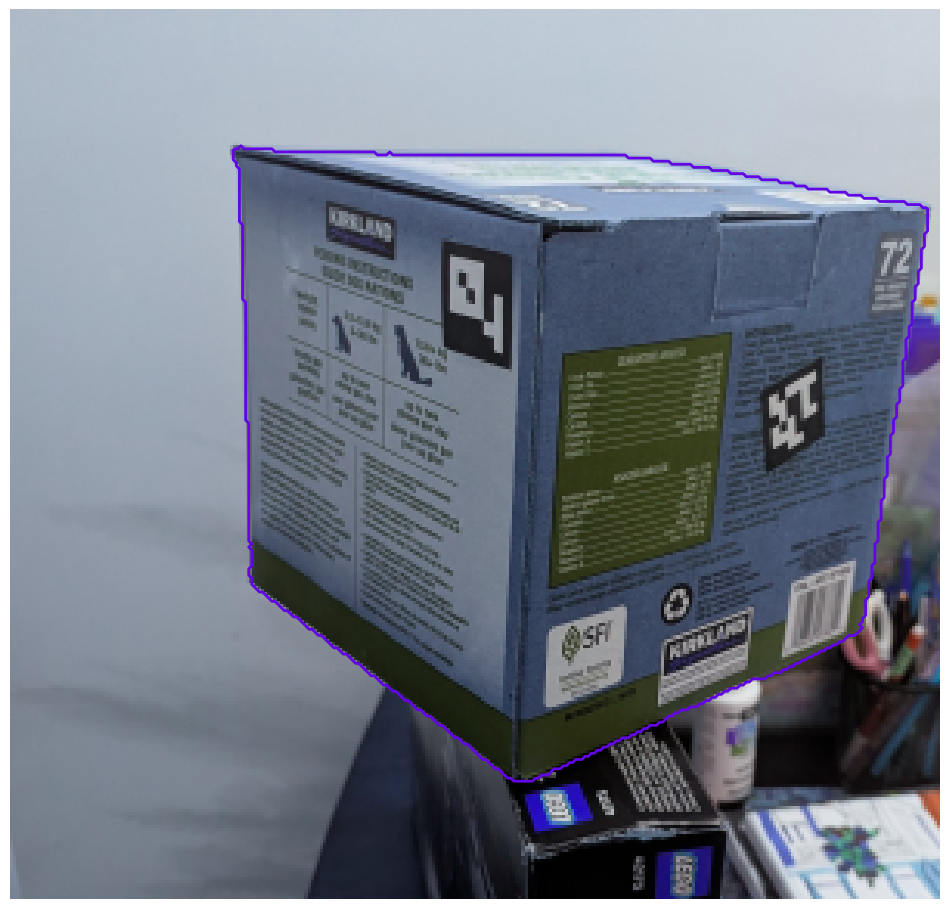

In [68]:
print("ROI")
r = sam_model(image, bboxes=bbox)
masks = r[0].masks.data.cpu().numpy() 
plot_mask_contours(image, masks)

In [25]:
def generate_aruco_marker(marker_id, size=200):
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
    marker_image = np.zeros((size, size), dtype=np.uint8)
    marker = cv2.aruco.generateImageMarker(aruco_dict, marker_id, size, marker_image, 1)
    border_size = size // 8
    return cv2.copyMakeBorder(
        marker,
        border_size,
        border_size,
        border_size,
        border_size,
        cv2.BORDER_CONSTANT,
        value=255
    )

def create_marker_grid(start_id, num_markers, marker_size=100):
    """
    Create a grid of ArUco markers in a single image
    """
    # Calculate grid dimensions
    grid_cols = 2  # number of columns
    grid_rows = (num_markers + 1) // 2  # number of rows, rounded up
    
    # Calculate full marker size including border
    border_size = marker_size // 8
    full_marker_size = marker_size + (2 * border_size)  # total size including borders
    
    # Create white background image
    padding = 50  # padding around the edges
    grid_image = np.ones((
        grid_rows * full_marker_size + 2 * padding,
        grid_cols * full_marker_size + 2 * padding
    ), dtype=np.uint8) * 255
    
    # Generate and place markers
    for i in range(num_markers):
        # Calculate grid position
        row = i // grid_cols
        col = i % grid_cols
        
        # Generate marker
        marker = generate_aruco_marker(start_id + i, marker_size)
        
        # Calculate position in grid
        y_pos = row * full_marker_size + padding
        x_pos = col * full_marker_size + padding
        
        # Place marker in grid
        grid_image[
            y_pos:y_pos + full_marker_size,
            x_pos:x_pos + full_marker_size
        ] = marker
        
        # Add marker ID below the marker
        # cv2.putText(
        #     grid_image,
        #     f"ID: {start_id + i}",
        #     (x_pos, y_pos + full_marker_size - 5),
        #     cv2.FONT_HERSHEY_SIMPLEX,
        #     0.4,
        #     0,
        #     1
        # )
    
    return grid_image

In [26]:
def gen_arucos():
    grid = create_marker_grid(0, 10, marker_size=100)
    cv2.imwrite(".data/aruco/aruco_markers_grid.png", grid)